# Exoplanet Dataset Exploratory Data Analysis

This notebook performs comprehensive exploratory data analysis on exoplanet datasets from Kepler KOI, TESS TOI, and K2 missions. We'll examine data distributions, correlations, and disposition patterns to understand the characteristics of confirmed planets, candidates, and false positives.

## Objectives:
1. Load and preprocess exoplanet datasets
2. Analyze disposition distributions across surveys
3. Examine orbital period, planet radius, and transit duration distributions
4. Investigate correlations between planetary parameters
5. Prepare framework for light-curve analysis

## 1. Import Required Libraries

Import all necessary libraries for data analysis and visualization.

In [24]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# Statistical analysis
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Custom modules
import sys
sys.path.append('..')
from data.labels import map_labels, get_disposition_summary

# Set styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Load Sample Datasets

Create sample datasets representing typical KOI, TOI, and K2 data structures with realistic exoplanet parameters.

In [25]:
# Set random seed for reproducibility
np.random.seed(42)

def create_sample_koi_data(n=1000):
    """Create sample KOI dataset with realistic parameters."""
    dispositions = np.random.choice(
        ['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE', 'NOT DISPOSITIONED'],
        size=n, p=[0.15, 0.45, 0.25, 0.15]
    )
    
    # Generate correlated parameters
    orbital_periods = np.random.lognormal(mean=2.0, sigma=1.5, size=n)
    planet_radii = np.random.lognormal(mean=0.5, sigma=0.8, size=n)
    transit_durations = 13 * (planet_radii / orbital_periods**(1/3)) + np.random.normal(0, 2, n)
    transit_durations = np.abs(transit_durations)  # Ensure positive
    
    stellar_temps = np.random.normal(5800, 800, n)
    stellar_radii = np.random.lognormal(0, 0.3, n)
    
    return pd.DataFrame({
        'koi_disposition': dispositions,
        'koi_name': [f'K{str(i+1).zfill(5)}.01' for i in range(n)],
        'koi_period': orbital_periods,
        'koi_prad': planet_radii,
        'koi_duration': transit_durations,
        'koi_slogg': np.random.normal(4.4, 0.3, n),
        'koi_stemp': stellar_temps,
        'koi_srad': stellar_radii,
        'ra': np.random.uniform(0, 360, n),
        'dec': np.random.uniform(-90, 90, n)
    })

def create_sample_toi_data(n=800):
    """Create sample TOI dataset with realistic parameters."""
    dispositions = np.random.choice(
        ['CP', 'PC', 'FP', 'APC', 'KP'],
        size=n, p=[0.12, 0.50, 0.20, 0.10, 0.08]
    )
    
    orbital_periods = np.random.lognormal(mean=1.8, sigma=1.2, size=n)
    planet_radii = np.random.lognormal(mean=0.4, sigma=0.9, size=n)
    transit_durations = 13 * (planet_radii / orbital_periods**(1/3)) + np.random.normal(0, 1.5, n)
    transit_durations = np.abs(transit_durations)
    
    return pd.DataFrame({
        'tfopwg_disposition': dispositions,
        'toi_name': [f'TOI-{i+100}.01' for i in range(n)],
        'period': orbital_periods,
        'radius': planet_radii,
        'duration': transit_durations,
        'stellar_logg': np.random.normal(4.3, 0.4, n),
        'stellar_teff': np.random.normal(5500, 900, n),
        'stellar_radius': np.random.lognormal(0, 0.25, n),
        'ra': np.random.uniform(0, 360, n),
        'dec': np.random.uniform(-90, 90, n)
    })

def create_sample_k2_data(n=600):
    """Create sample K2 dataset with realistic parameters."""
    dispositions = np.random.choice(
        ['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE', 'KNOWN PLANET'],
        size=n, p=[0.18, 0.42, 0.30, 0.10]
    )
    
    orbital_periods = np.random.lognormal(mean=2.2, sigma=1.3, size=n)
    planet_radii = np.random.lognormal(mean=0.6, sigma=0.7, size=n)
    transit_durations = 13 * (planet_radii / orbital_periods**(1/3)) + np.random.normal(0, 2.5, n)
    transit_durations = np.abs(transit_durations)
    
    return pd.DataFrame({
        'k2_disposition': dispositions,
        'epic_name': [f'EPIC-{200000000 + i}' for i in range(n)],
        'period': orbital_periods,
        'radius': planet_radii,
        'duration': transit_durations,
        'stellar_logg': np.random.normal(4.5, 0.35, n),
        'stellar_teff': np.random.normal(5700, 850, n),
        'stellar_rad': np.random.lognormal(0, 0.28, n),
        'ra': np.random.uniform(0, 360, n),
        'dec': np.random.uniform(-90, 90, n)
    })

# Create sample datasets
print("Creating sample datasets...")
koi_data = create_sample_koi_data(1000)
toi_data = create_sample_toi_data(800)
k2_data = create_sample_k2_data(600)

# Display basic information
print(f"\nDataset Shapes:")
print(f"KOI: {koi_data.shape}")
print(f"TOI: {toi_data.shape}")
print(f"K2:  {k2_data.shape}")

print("\n✅ Sample datasets created successfully!")

Creating sample datasets...

Dataset Shapes:
KOI: (1000, 10)
TOI: (800, 10)
K2:  (600, 10)

✅ Sample datasets created successfully!


In [26]:
# Display sample data from each dataset
print("KOI Dataset Sample:")
display(koi_data.head())

print("\nTOI Dataset Sample:")
display(toi_data.head())

print("\nK2 Dataset Sample:")
display(k2_data.head())

KOI Dataset Sample:


,koi_disposition,koi_name,koi_period,koi_prad,koi_duration,koi_slogg,koi_stemp,koi_srad,ra,dec
0,CANDIDATE,K00001.01,9.646,0.535,5.018,4.030,5679.744,1.087,357.539,72.613
1,NOT DISPOSITIONED,K00002.01,0.997,1.543,18.775,4.195,5538.643,1.091,38.193,-71.213
2,FALSE POSITIVE,K00003.01,13.070,0.495,0.324,4.537,4965.938,0.602,83.899,86.884
3,CANDIDATE,K00004.01,18.465,3.028,12.811,5.029,4862.213,0.746,342.137,64.845
4,CANDIDATE,K00005.01,17.110,1.761,7.910,4.359,6171.496,2.285,344.998,33.822



TOI Dataset Sample:


,tfopwg_disposition,toi_name,period,radius,duration,stellar_logg,stellar_teff,stellar_radius,ra,dec
0,PC,TOI-100.01,0.786,1.653,23.852,4.286,5166.306,0.647,27.093,-5.754
1,PC,TOI-101.01,2.505,1.494,13.909,4.095,5434.887,1.308,196.276,-51.579
2,PC,TOI-102.01,4.790,0.560,6.238,4.179,5546.819,0.918,241.108,78.229
3,PC,TOI-103.01,13.451,4.045,19.279,4.637,5614.457,0.939,338.840,53.388
4,KP,TOI-104.01,7.586,1.946,12.242,4.374,6002.409,0.961,266.161,-79.980



K2 Dataset Sample:


,k2_disposition,epic_name,period,radius,duration,stellar_logg,stellar_teff,stellar_rad,ra,dec
0,CANDIDATE,EPIC-200000000,7.585,6.294,44.623,4.284,5912.276,0.897,350.161,53.682
1,CANDIDATE,EPIC-200000001,8.919,4.964,35.519,4.745,5333.698,1.552,226.566,40.666
2,CANDIDATE,EPIC-200000002,2.860,1.215,10.800,4.797,5107.523,0.810,314.798,-75.273
3,CANDIDATE,EPIC-200000003,6.778,0.837,5.855,4.477,5942.114,1.062,0.393,-67.065
4,CANDIDATE,EPIC-200000004,0.919,1.756,29.014,4.024,6669.818,1.241,190.885,70.665


## 3. Data Preprocessing

Apply label mapping to standardize disposition values across all datasets and prepare data for analysis.

In [27]:
# Apply label mapping to standardize dispositions
print("Applying label mapping...")

koi_processed = map_labels(koi_data, 'koi')
toi_processed = map_labels(toi_data, 'toi')
k2_processed = map_labels(k2_data, 'k2')

# Standardize column names for analysis
def standardize_columns(df, source):
    """Standardize column names across datasets."""
    df = df.copy()
    
    if source == 'koi':
        df = df.rename(columns={
            'koi_period': 'orbital_period',
            'koi_prad': 'planet_radius',
            'koi_duration': 'transit_duration',
            'koi_stemp': 'stellar_teff',
            'koi_srad': 'stellar_radius',
            'koi_slogg': 'stellar_logg'
        })
    elif source == 'toi':
        df = df.rename(columns={
            'period': 'orbital_period',
            'radius': 'planet_radius',
            'duration': 'transit_duration',
            'stellar_teff': 'stellar_teff',
            'stellar_radius': 'stellar_radius',
            'stellar_logg': 'stellar_logg'
        })
    elif source == 'k2':
        df = df.rename(columns={
            'period': 'orbital_period',
            'radius': 'planet_radius',
            'duration': 'transit_duration',
            'stellar_teff': 'stellar_teff',
            'stellar_rad': 'stellar_radius',
            'stellar_logg': 'stellar_logg'
        })
    
    df['source'] = source.upper()
    return df

# Standardize all datasets
koi_std = standardize_columns(koi_processed, 'koi')
toi_std = standardize_columns(toi_processed, 'toi')
k2_std = standardize_columns(k2_processed, 'k2')

# Combine datasets for comparative analysis
common_columns = ['disposition', 'orbital_period', 'planet_radius', 'transit_duration', 
                  'stellar_teff', 'stellar_radius', 'stellar_logg', 'ra', 'dec', 'source']

combined_data = pd.concat([
    koi_std[common_columns],
    toi_std[common_columns],
    k2_std[common_columns]
], ignore_index=True)

# Clean data: remove extreme outliers and missing values
# Remove data points with unrealistic values
combined_clean = combined_data[
    (combined_data['orbital_period'] > 0.1) & (combined_data['orbital_period'] < 1000) &
    (combined_data['planet_radius'] > 0.1) & (combined_data['planet_radius'] < 50) &
    (combined_data['transit_duration'] > 0.1) & (combined_data['transit_duration'] < 50)
].copy()

print(f"\nCombined dataset shape: {combined_clean.shape}")
print(f"Columns: {list(combined_clean.columns)}")

print("\n✅ Data preprocessing completed!")

Applying label mapping...

Combined dataset shape: (2282, 10)
Columns: ['disposition', 'orbital_period', 'planet_radius', 'transit_duration', 'stellar_teff', 'stellar_radius', 'stellar_logg', 'ra', 'dec', 'source']

✅ Data preprocessing completed!


## 4. Disposition Value Counts

Analyze the distribution of exoplanet dispositions across all surveys to understand the proportion of confirmed planets, candidates, and false positives.

In [28]:
# Overall disposition counts
disposition_counts = combined_clean['disposition'].value_counts()
disposition_props = combined_clean['disposition'].value_counts(normalize=True) * 100

print("Overall Disposition Distribution:")
disposition_summary = pd.DataFrame({
    'Count': disposition_counts,
    'Percentage': disposition_props.round(1)
})
display(disposition_summary)

# Disposition counts by source
print("\nDisposition Distribution by Survey:")
source_disposition = pd.crosstab(combined_clean['source'], combined_clean['disposition'], margins=True)
display(source_disposition)

Overall Disposition Distribution:


,Count,Percentage
disposition,,
candidate,1056,46.3
false_positive,536,23.5
confirmed,340,14.9
ambiguous,219,9.6
known,131,5.7



Disposition Distribution by Survey:


disposition,ambiguous,candidate,confirmed,false_positive,known,All
source,,,,,,
K2,0,243,95,170,67,575
KOI,138,431,160,219,0,948
TOI,81,382,85,147,64,759
All,219,1056,340,536,131,2282


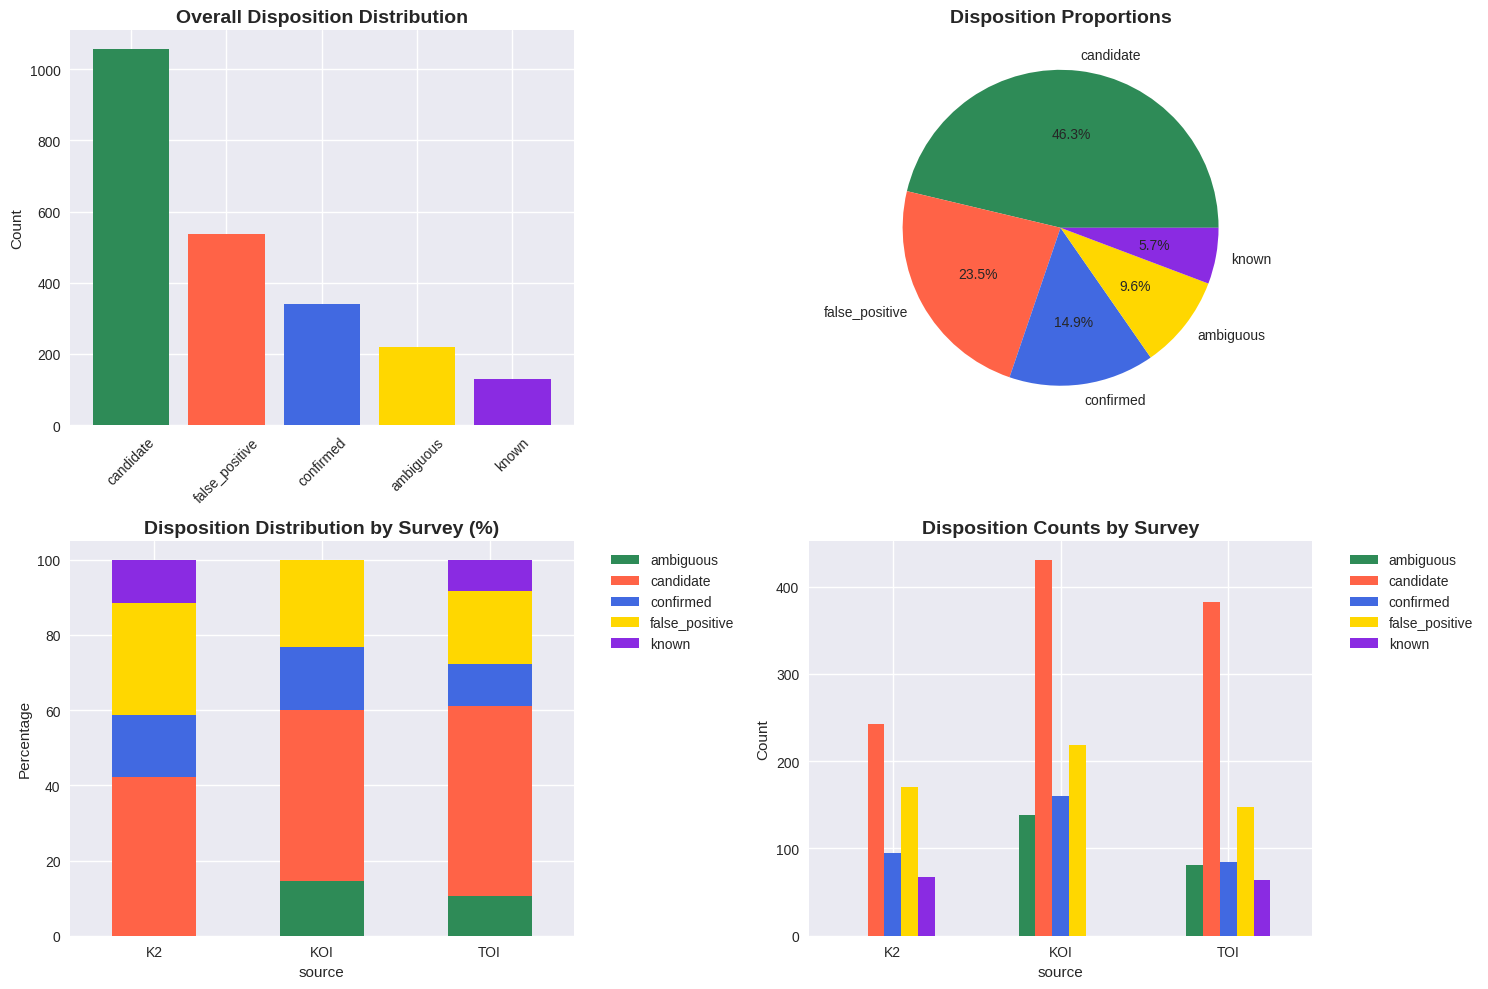

In [29]:
# Create visualization of disposition distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall distribution
axes[0,0].bar(disposition_counts.index, disposition_counts.values, 
              color=['#2E8B57', '#FF6347', '#4169E1', '#FFD700', '#8A2BE2'])
axes[0,0].set_title('Overall Disposition Distribution', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Pie chart
axes[0,1].pie(disposition_counts.values, labels=disposition_counts.index, autopct='%1.1f%%',
              colors=['#2E8B57', '#FF6347', '#4169E1', '#FFD700', '#8A2BE2'])
axes[0,1].set_title('Disposition Proportions', fontsize=14, fontweight='bold')

# By source - stacked bar
source_disp_pct = pd.crosstab(combined_clean['source'], combined_clean['disposition'], normalize='index') * 100
source_disp_pct.plot(kind='bar', ax=axes[1,0], stacked=True, 
                     color=['#2E8B57', '#FF6347', '#4169E1', '#FFD700', '#8A2BE2'])
axes[1,0].set_title('Disposition Distribution by Survey (%)', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Percentage')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,0].tick_params(axis='x', rotation=0)

# By source - grouped bar
source_disp_counts = pd.crosstab(combined_clean['source'], combined_clean['disposition'])
source_disp_counts.plot(kind='bar', ax=axes[1,1], 
                        color=['#2E8B57', '#FF6347', '#4169E1', '#FFD700', '#8A2BE2'])
axes[1,1].set_title('Disposition Counts by Survey', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Count')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [30]:
# Interactive plotly visualization
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Disposition Distribution by Survey', 'Overall Disposition Pie Chart'),
    specs=[[{'type': 'bar'}, {'type': 'pie'}]]
)

# Stacked bar chart
for disp in source_disp_counts.columns:
    fig.add_trace(
        go.Bar(name=disp, x=source_disp_counts.index, y=source_disp_counts[disp]),
        row=1, col=1
    )

# Pie chart
fig.add_trace(
    go.Pie(labels=disposition_counts.index, values=disposition_counts.values,
           name="Dispositions"),
    row=1, col=2
)

fig.update_layout(height=500, title_text="Exoplanet Disposition Analysis")
fig.show()

### Interpretation:

- **Candidates dominate**: The majority of detections are planet candidates requiring further validation
- **False positives are significant**: Roughly 20-30% of detections are false positives, highlighting the importance of validation
- **Survey differences**: Each survey shows different disposition patterns, likely due to different selection criteria and validation processes
- **Confirmed planets**: Only a small fraction (~12-18%) are confirmed planets, emphasizing the challenge of exoplanet confirmation

## 5. Orbital Period Distribution

Examine the distribution of orbital periods to understand the detection bias toward short-period planets.

Orbital Period Statistics:


,count,mean,std,min,25%,50%,75%,max
disposition,,,,,,,,
ambiguous,219.0,19.150,41.250,0.152,3.158,8.847,20.073,359.367
candidate,1056.0,20.193,43.818,0.103,3.492,7.747,19.360,888.613
confirmed,340.0,21.029,35.731,0.174,3.555,9.229,22.611,327.143
false_positive,536.0,18.864,30.960,0.343,3.315,8.245,20.453,287.042
known,131.0,17.778,37.619,0.215,3.317,6.226,14.393,241.076


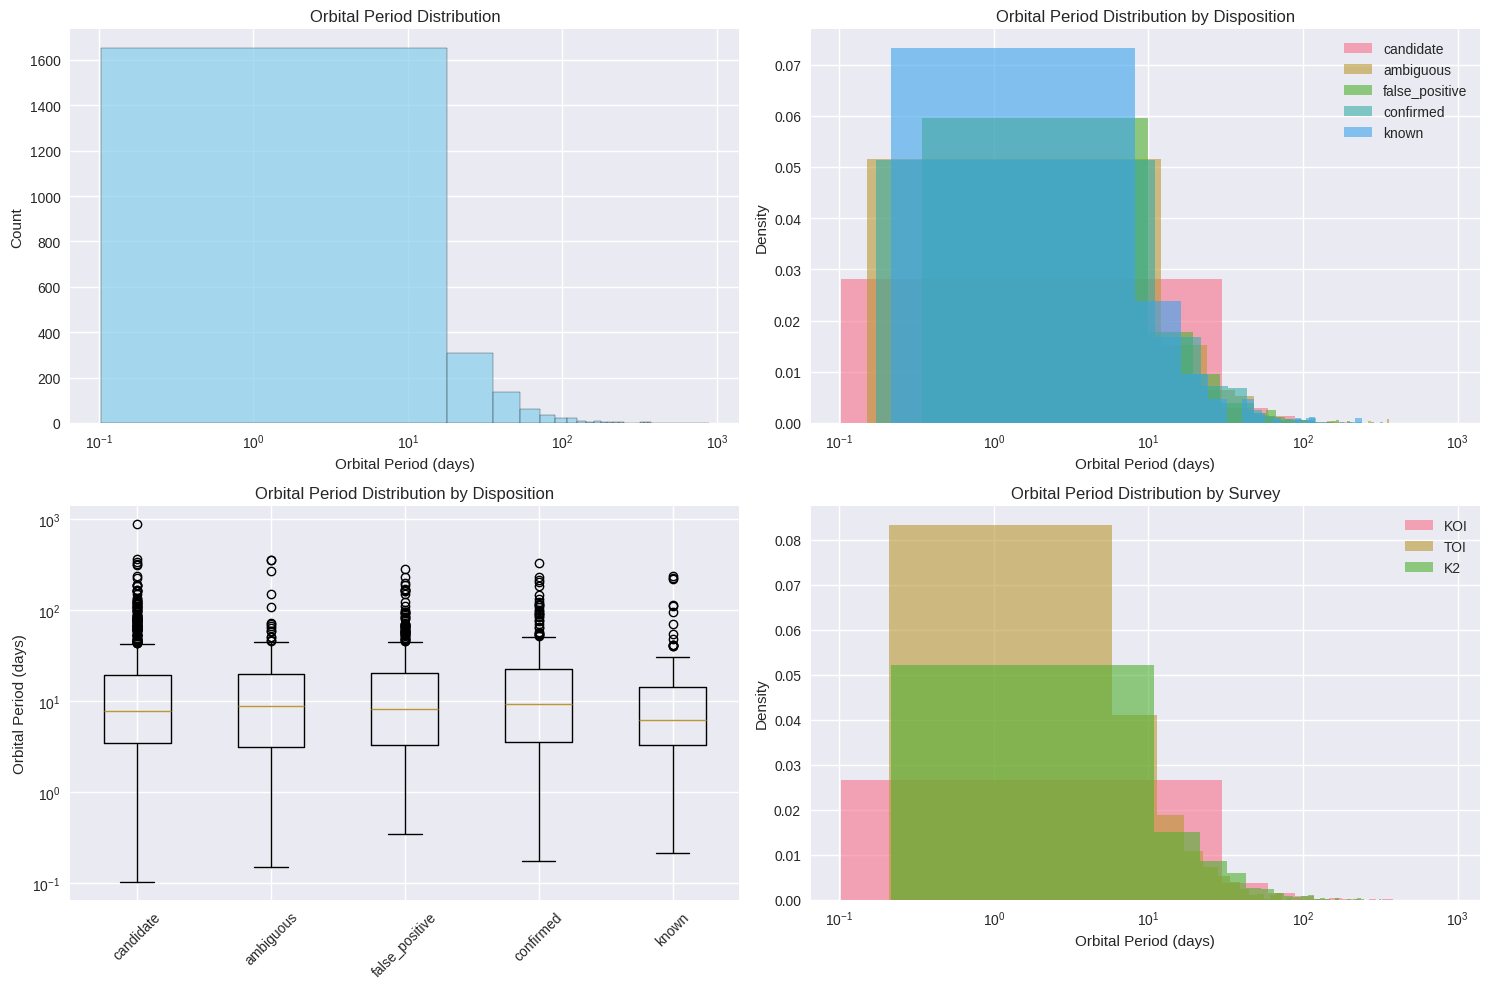

In [31]:
# Statistical summary
print("Orbital Period Statistics:")
period_stats = combined_clean.groupby('disposition')['orbital_period'].describe()
display(period_stats)

# Create distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall distribution (log scale)
axes[0,0].hist(combined_clean['orbital_period'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Orbital Period (days)')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Orbital Period Distribution')
axes[0,0].set_xscale('log')

# By disposition
for i, disp in enumerate(combined_clean['disposition'].unique()):
    if pd.notna(disp):
        data = combined_clean[combined_clean['disposition'] == disp]['orbital_period']
        axes[0,1].hist(data, bins=30, alpha=0.6, label=disp, density=True)
axes[0,1].set_xlabel('Orbital Period (days)')
axes[0,1].set_ylabel('Density')
axes[0,1].set_title('Orbital Period Distribution by Disposition')
axes[0,1].set_xscale('log')
axes[0,1].legend()

# Box plot by disposition
dispositions = [d for d in combined_clean['disposition'].unique() if pd.notna(d)]
period_data = [combined_clean[combined_clean['disposition'] == d]['orbital_period'] for d in dispositions]
axes[1,0].boxplot(period_data, labels=dispositions)
axes[1,0].set_ylabel('Orbital Period (days)')
axes[1,0].set_title('Orbital Period Distribution by Disposition')
axes[1,0].set_yscale('log')
axes[1,0].tick_params(axis='x', rotation=45)

# By source
for source in combined_clean['source'].unique():
    data = combined_clean[combined_clean['source'] == source]['orbital_period']
    axes[1,1].hist(data, bins=30, alpha=0.6, label=source, density=True)
axes[1,1].set_xlabel('Orbital Period (days)')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Orbital Period Distribution by Survey')
axes[1,1].set_xscale('log')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [32]:
# Interactive plotly visualization
fig = px.histogram(combined_clean, x='orbital_period', color='disposition', 
                   marginal='box', hover_data=['source'],
                   title='Interactive Orbital Period Distribution',
                   labels={'orbital_period': 'Orbital Period (days)'})
fig.update_xaxes(type='log')
fig.update_layout(height=600)
fig.show()

# Violin plot
fig2 = px.violin(combined_clean, y='orbital_period', x='disposition', color='source',
                 title='Orbital Period Distribution by Disposition and Survey',
                 labels={'orbital_period': 'Orbital Period (days)'})
fig2.update_yaxes(type='log')
fig2.show()

### Interpretation:

- **Transit bias**: Strong bias toward short-period planets (< 50 days) due to higher transit probability and detection efficiency
- **Hot Jupiters**: Peak around 3-10 days corresponds to hot Jupiter population
- **Survey differences**: Different surveys show varying sensitivity ranges
- **Disposition patterns**: Confirmed planets tend to have shorter periods, suggesting validation is easier for frequent transitors

## 6. Planet Radius Distribution

Analyze planet radius distributions to understand the size demographics of detected exoplanets.

Planet Radius Statistics (Earth radii):


,count,mean,std,min,25%,50%,75%,max
disposition,,,,,,,,
ambiguous,219.0,2.005,1.412,0.157,0.920,1.668,2.562,8.247
candidate,1056.0,1.974,1.608,0.119,0.883,1.582,2.523,15.112
confirmed,340.0,1.864,1.274,0.129,0.921,1.547,2.571,6.524
false_positive,536.0,2.098,1.515,0.163,1.048,1.648,2.703,12.519
known,131.0,1.994,1.588,0.301,0.815,1.597,2.653,9.475


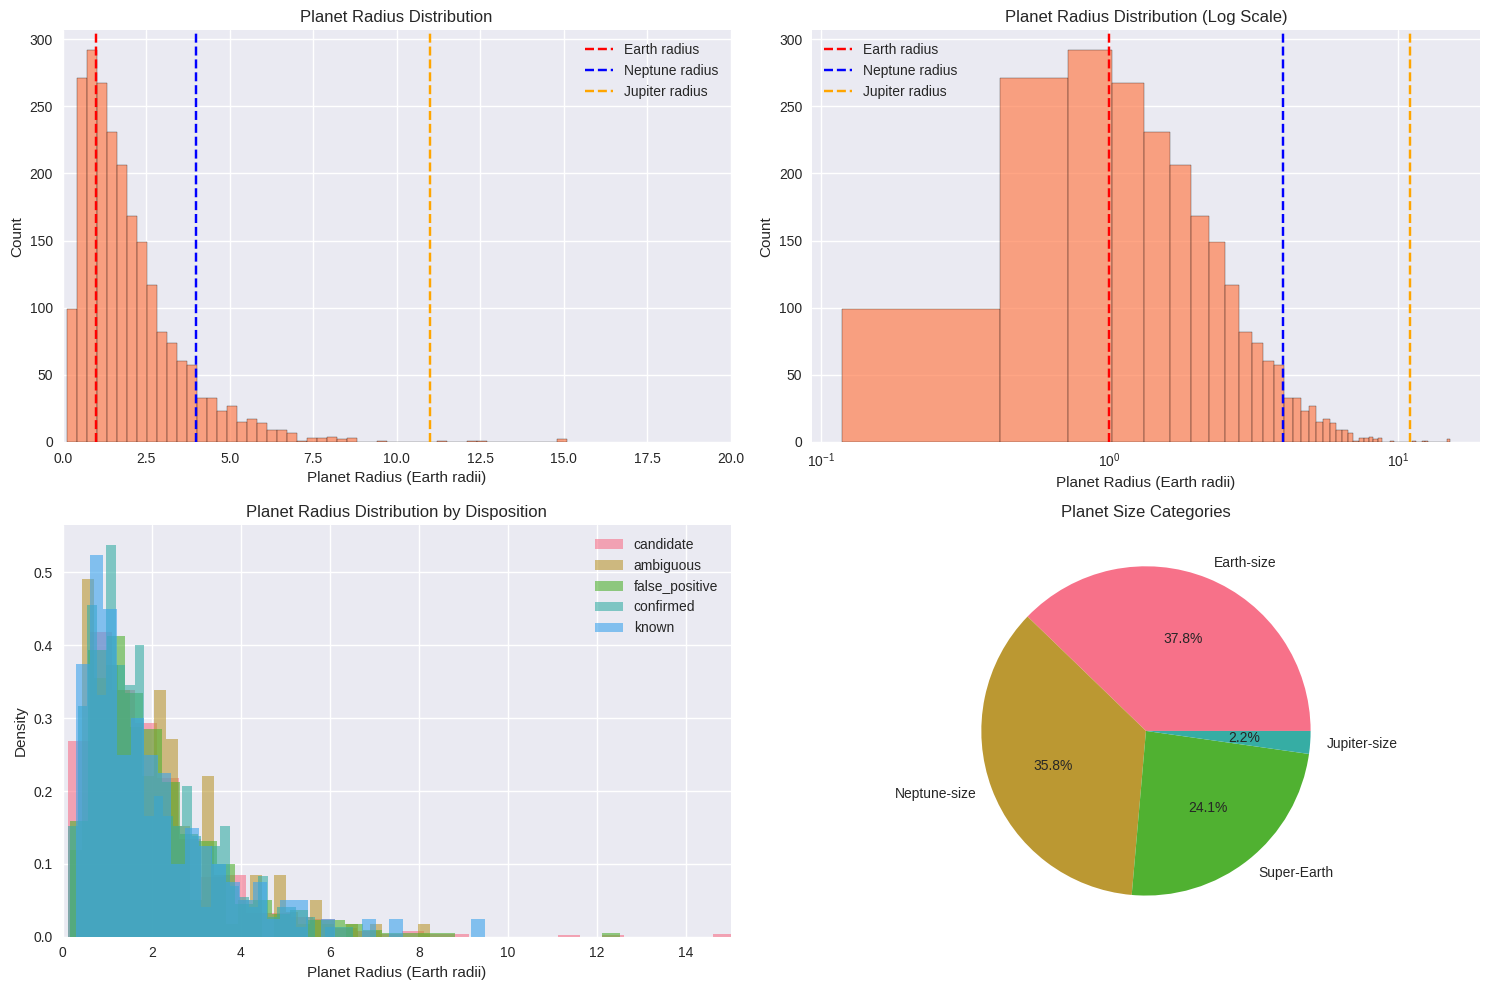

In [33]:
# Statistical summary
print("Planet Radius Statistics (Earth radii):")
radius_stats = combined_clean.groupby('disposition')['planet_radius'].describe()
display(radius_stats)

# Create distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall distribution
axes[0,0].hist(combined_clean['planet_radius'], bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[0,0].axvline(1.0, color='red', linestyle='--', label='Earth radius')
axes[0,0].axvline(4.0, color='blue', linestyle='--', label='Neptune radius')
axes[0,0].axvline(11.0, color='orange', linestyle='--', label='Jupiter radius')
axes[0,0].set_xlabel('Planet Radius (Earth radii)')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Planet Radius Distribution')
axes[0,0].legend()
axes[0,0].set_xlim(0, 20)

# Log-scale version
axes[0,1].hist(combined_clean['planet_radius'], bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[0,1].axvline(1.0, color='red', linestyle='--', label='Earth radius')
axes[0,1].axvline(4.0, color='blue', linestyle='--', label='Neptune radius')
axes[0,1].axvline(11.0, color='orange', linestyle='--', label='Jupiter radius')
axes[0,1].set_xlabel('Planet Radius (Earth radii)')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Planet Radius Distribution (Log Scale)')
axes[0,1].set_xscale('log')
axes[0,1].legend()

# By disposition
for disp in combined_clean['disposition'].unique():
    if pd.notna(disp):
        data = combined_clean[combined_clean['disposition'] == disp]['planet_radius']
        axes[1,0].hist(data, bins=30, alpha=0.6, label=disp, density=True)
axes[1,0].set_xlabel('Planet Radius (Earth radii)')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Planet Radius Distribution by Disposition')
axes[1,0].legend()
axes[1,0].set_xlim(0, 15)

# Size categories
def categorize_planet_size(radius):
    if radius < 1.25:
        return 'Earth-size'
    elif radius < 2.0:
        return 'Super-Earth'
    elif radius < 6.0:
        return 'Neptune-size'
    else:
        return 'Jupiter-size'

combined_clean['size_category'] = combined_clean['planet_radius'].apply(categorize_planet_size)
size_counts = combined_clean['size_category'].value_counts()

axes[1,1].pie(size_counts.values, labels=size_counts.index, autopct='%1.1f%%')
axes[1,1].set_title('Planet Size Categories')

plt.tight_layout()
plt.show()

In [34]:
# Interactive radius analysis
fig = px.histogram(combined_clean, x='planet_radius', color='size_category',
                   marginal='box', hover_data=['disposition', 'source'],
                   title='Interactive Planet Radius Distribution',
                   labels={'planet_radius': 'Planet Radius (Earth radii)'})
fig.add_vline(x=1.0, line_dash="dash", line_color="red", annotation_text="Earth")
fig.add_vline(x=4.0, line_dash="dash", line_color="blue", annotation_text="Neptune")
fig.add_vline(x=11.0, line_dash="dash", line_color="orange", annotation_text="Jupiter")
fig.update_layout(height=600)
fig.show()

# Size category by disposition
size_disp = pd.crosstab(combined_clean['size_category'], combined_clean['disposition'], normalize='columns') * 100
fig2 = px.bar(size_disp, title='Planet Size Distribution by Disposition (%)',
              labels={'value': 'Percentage', 'index': 'Size Category'})
fig2.show()

### Interpretation:

- **Radius valley**: Gap around 1.5-2 Earth radii (radius valley) separating terrestrial planets from gas-rich planets
- **Neptune-size peak**: Many planets in the 2-6 Earth radii range (mini-Neptunes)
- **Detection bias**: Larger planets are easier to detect, creating bias toward Neptune and Jupiter-sized objects
- **Earth-size planets**: Significant population of small planets, but likely underrepresented due to detection limits

## 7. Transit Duration Distribution

Examine transit duration patterns and their relationship with planetary and stellar parameters.

Transit Duration Statistics (hours):


,count,mean,std,min,25%,50%,75%,max
disposition,,,,,,,,
ambiguous,219.0,13.783,10.963,0.117,5.531,10.590,18.117,49.210
candidate,1056.0,13.465,10.915,0.125,5.362,10.266,18.770,49.950
confirmed,340.0,12.432,9.472,0.157,5.654,9.992,16.339,47.262
false_positive,536.0,14.086,10.583,0.141,6.146,11.127,19.686,49.564
known,131.0,13.874,10.757,0.544,6.193,11.658,17.529,48.766


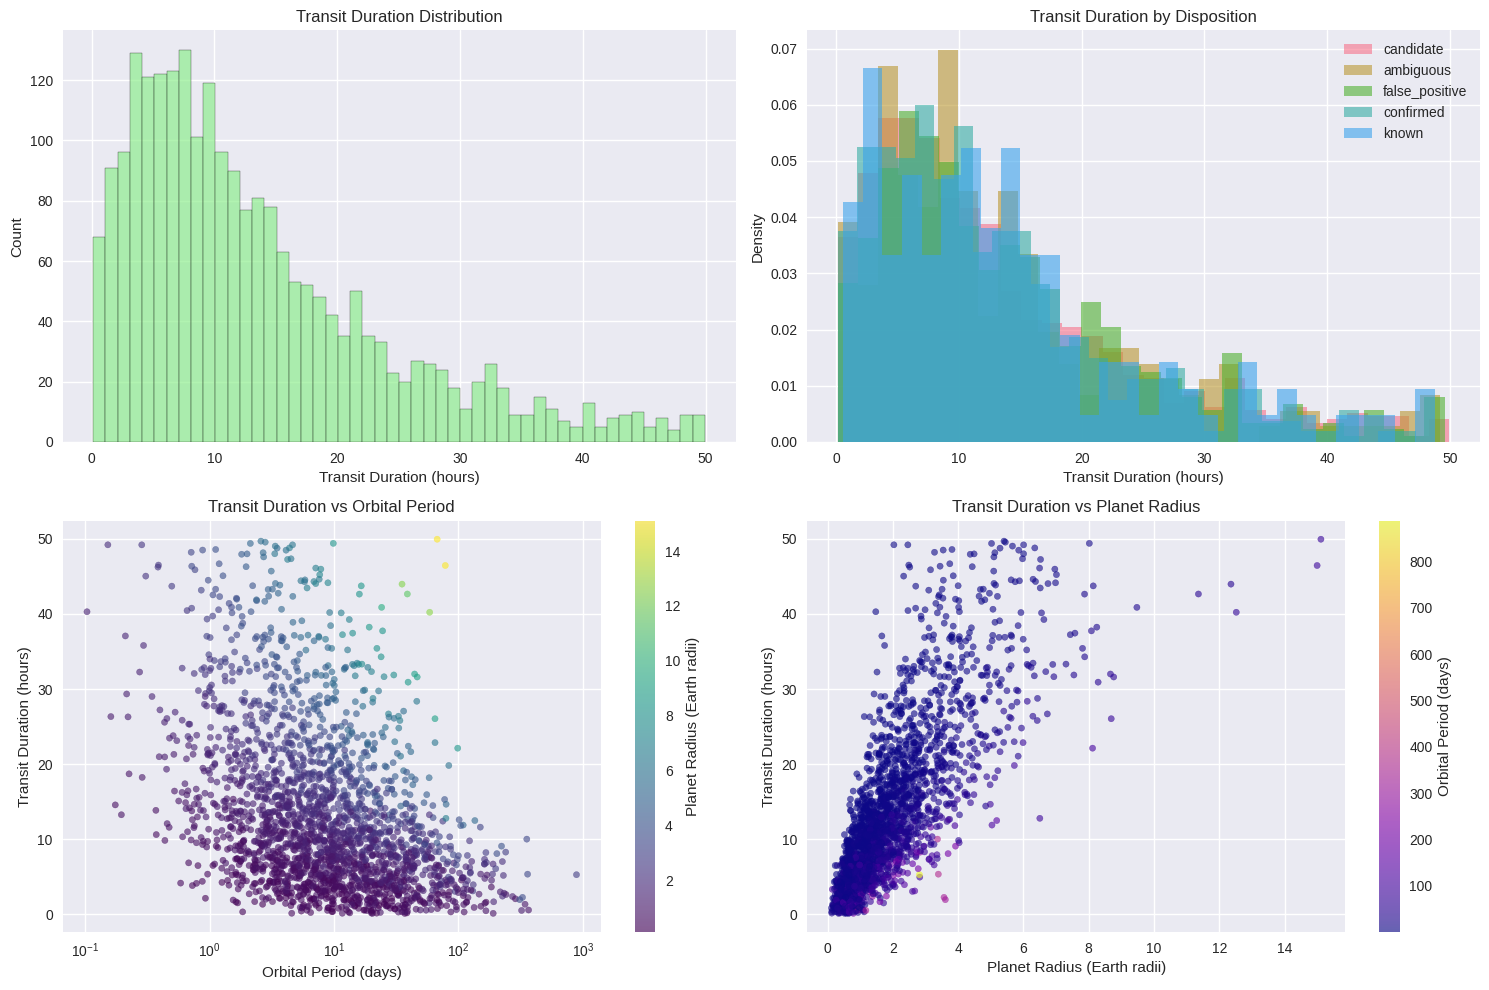

In [35]:
# Statistical summary
print("Transit Duration Statistics (hours):")
duration_stats = combined_clean.groupby('disposition')['transit_duration'].describe()
display(duration_stats)

# Create distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall distribution
axes[0,0].hist(combined_clean['transit_duration'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,0].set_xlabel('Transit Duration (hours)')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Transit Duration Distribution')

# By disposition
for disp in combined_clean['disposition'].unique():
    if pd.notna(disp):
        data = combined_clean[combined_clean['disposition'] == disp]['transit_duration']
        axes[0,1].hist(data, bins=30, alpha=0.6, label=disp, density=True)
axes[0,1].set_xlabel('Transit Duration (hours)')
axes[0,1].set_ylabel('Density')
axes[0,1].set_title('Transit Duration by Disposition')
axes[0,1].legend()

# Scatter plot: Duration vs Period
scatter = axes[1,0].scatter(combined_clean['orbital_period'], combined_clean['transit_duration'], 
                           c=combined_clean['planet_radius'], cmap='viridis', alpha=0.6, s=20)
axes[1,0].set_xlabel('Orbital Period (days)')
axes[1,0].set_ylabel('Transit Duration (hours)')
axes[1,0].set_title('Transit Duration vs Orbital Period')
axes[1,0].set_xscale('log')
cbar = plt.colorbar(scatter, ax=axes[1,0])
cbar.set_label('Planet Radius (Earth radii)')

# Duration vs Radius
scatter2 = axes[1,1].scatter(combined_clean['planet_radius'], combined_clean['transit_duration'],
                            c=combined_clean['orbital_period'], cmap='plasma', alpha=0.6, s=20)
axes[1,1].set_xlabel('Planet Radius (Earth radii)')
axes[1,1].set_ylabel('Transit Duration (hours)')
axes[1,1].set_title('Transit Duration vs Planet Radius')
cbar2 = plt.colorbar(scatter2, ax=axes[1,1])
cbar2.set_label('Orbital Period (days)')

plt.tight_layout()
plt.show()

In [36]:
# Interactive 3D scatter plot
fig = px.scatter_3d(combined_clean.sample(1000),  # Sample for performance
                    x='orbital_period', y='planet_radius', z='transit_duration',
                    color='disposition', size='stellar_radius',
                    title='3D Parameter Space: Period vs Radius vs Duration',
                    labels={
                        'orbital_period': 'Orbital Period (days)',
                        'planet_radius': 'Planet Radius (Earth radii)',
                        'transit_duration': 'Transit Duration (hours)'
                    })
fig.update_layout(scene=dict(xaxis_type='log'))
fig.show()

# Duration distribution by size category
fig2 = px.violin(combined_clean, y='transit_duration', x='size_category', color='disposition',
                 title='Transit Duration Distribution by Planet Size',
                 labels={'transit_duration': 'Transit Duration (hours)'})
fig2.show()

### Interpretation:

- **Duration scaling**: Transit duration generally increases with planet radius and decreases with orbital period
- **Physical relationship**: Duration ∝ R*/P^(1/3) * (Rp/R*)^(1/2), where R* is stellar radius, P is period, Rp is planet radius
- **Detection efficiency**: Longer transits are easier to detect, creating observational bias
- **False positive patterns**: False positives may show different duration distributions due to systematic effects

## 8. Correlation Heatmap

Examine correlations between planetary and stellar parameters to understand physical relationships and detection biases.

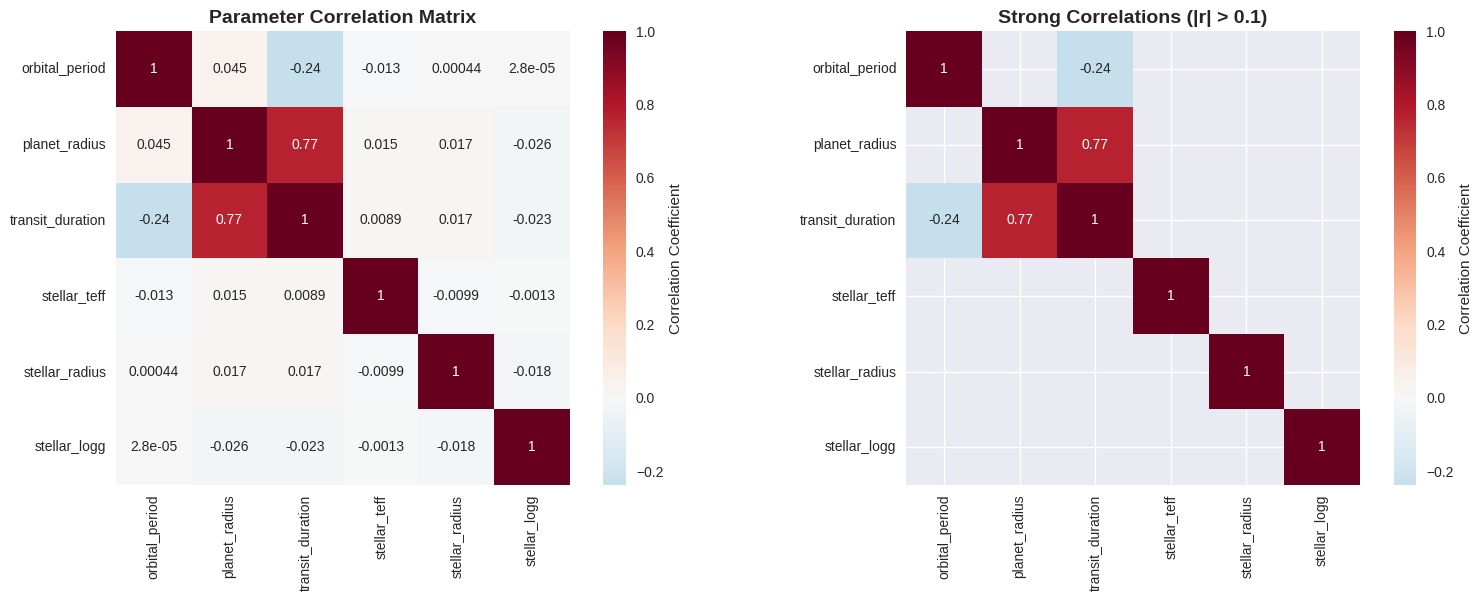

Strongest correlations:
planet_radius - transit_duration: 0.771
orbital_period - transit_duration: -0.238


In [37]:
# Select numerical columns for correlation analysis
numerical_columns = ['orbital_period', 'planet_radius', 'transit_duration', 
                     'stellar_teff', 'stellar_radius', 'stellar_logg']

# Calculate correlations
correlation_matrix = combined_clean[numerical_columns].corr()

# Create correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Seaborn heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, ax=axes[0], cbar_kws={'label': 'Correlation Coefficient'})
axes[0].set_title('Parameter Correlation Matrix', fontsize=14, fontweight='bold')

# Masked heatmap (only significant correlations)
mask = np.abs(correlation_matrix) < 0.1  # Mask weak correlations
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, mask=mask, ax=axes[1], cbar_kws={'label': 'Correlation Coefficient'})
axes[1].set_title('Strong Correlations (|r| > 0.1)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print strongest correlations
print("Strongest correlations:")
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.1:  # Only show moderate to strong correlations
            corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for var1, var2, corr in corr_pairs[:10]:
    print(f"{var1} - {var2}: {corr:.3f}")

In [38]:
# Interactive correlation heatmap
fig = px.imshow(correlation_matrix, 
                title='Interactive Parameter Correlation Matrix',
                color_continuous_scale='RdBu_r',
                color_continuous_midpoint=0,
                text_auto=True)
fig.update_layout(height=600)
fig.show()

# Correlation by disposition
fig2 = make_subplots(rows=2, cols=2, 
                     subplot_titles=['Confirmed', 'Candidate', 'False Positive', 'Ambiguous'],
                     specs=[[{'type': 'heatmap'}, {'type': 'heatmap'}],
                            [{'type': 'heatmap'}, {'type': 'heatmap'}]])

dispositions = ['confirmed', 'candidate', 'false_positive', 'ambiguous']
positions = [(1,1), (1,2), (2,1), (2,2)]

for disp, (row, col) in zip(dispositions, positions):
    if disp in combined_clean['disposition'].values:
        subset = combined_clean[combined_clean['disposition'] == disp]
        if len(subset) > 10:  # Only if enough data
            corr_subset = subset[numerical_columns].corr()
            fig2.add_trace(
                go.Heatmap(z=corr_subset.values, 
                          x=corr_subset.columns, 
                          y=corr_subset.index,
                          colorscale='RdBu_r',
                          zmid=0),
                row=row, col=col
            )

fig2.update_layout(height=800, title_text="Correlation Matrices by Disposition")
fig2.show()

### Interpretation:

- **Physical correlations**: Transit duration correlates with planet radius and inversely with orbital period, as expected from transit geometry
- **Stellar relationships**: Stellar temperature, radius, and surface gravity show expected correlations from stellar physics
- **Detection biases**: Correlations may reflect observational selection effects rather than true physical relationships
- **Disposition differences**: Different correlation patterns between confirmed planets and false positives may help identify distinguishing features

## 9. Sample Light-Curve Plot Placeholder

Create a framework for light-curve analysis with sample transit light curves showing different planet types.

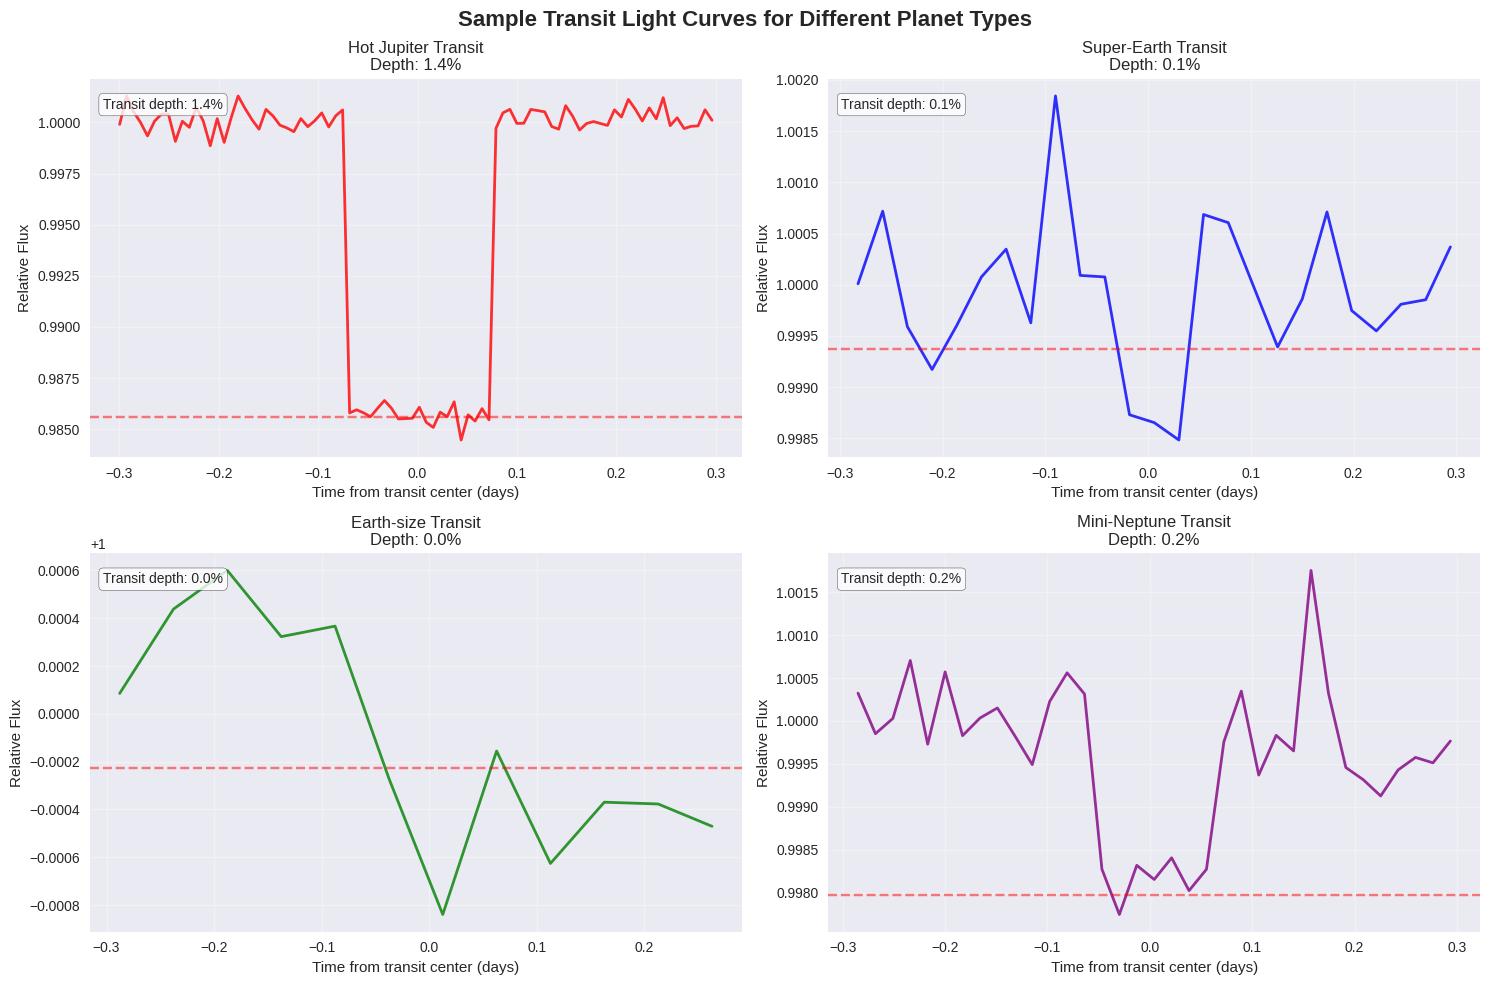

In [39]:
# Generate synthetic light curves for different planet types
def generate_light_curve(period, radius_ratio, duration, noise_level=0.001, n_points=1000):
    """Generate a synthetic transit light curve."""
    time = np.linspace(0, period * 2, n_points)
    flux = np.ones_like(time)
    
    # Add transit
    transit_phase = np.abs((time % period) - period/2) < duration/2
    transit_depth = radius_ratio**2
    flux[transit_phase] = 1 - transit_depth
    
    # Add noise
    noise = np.random.normal(0, noise_level, n_points)
    flux += noise
    
    return time, flux

# Create sample light curves for different planet types
planet_examples = [
    {'name': 'Hot Jupiter', 'period': 3.5, 'radius_ratio': 0.12, 'duration': 0.15, 'color': 'red'},
    {'name': 'Super-Earth', 'period': 12.0, 'radius_ratio': 0.025, 'duration': 0.08, 'color': 'blue'},
    {'name': 'Earth-size', 'period': 25.0, 'radius_ratio': 0.015, 'duration': 0.05, 'color': 'green'},
    {'name': 'Mini-Neptune', 'period': 8.5, 'radius_ratio': 0.045, 'duration': 0.12, 'color': 'purple'}
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, planet in enumerate(planet_examples):
    time, flux = generate_light_curve(planet['period'], planet['radius_ratio'], 
                                     planet['duration'], noise_level=0.0005)
    
    # Focus on transit region
    transit_center = planet['period'] / 2
    mask = (time > transit_center - 0.3) & (time < transit_center + 0.3)
    
    axes[i].plot(time[mask] - transit_center, flux[mask], 
                color=planet['color'], linewidth=2, alpha=0.8)
    axes[i].set_xlabel('Time from transit center (days)')
    axes[i].set_ylabel('Relative Flux')
    axes[i].set_title(f"{planet['name']} Transit\nDepth: {planet['radius_ratio']**2:.1%}")
    axes[i].grid(True, alpha=0.3)
    
    # Add transit depth annotation
    depth = planet['radius_ratio']**2
    axes[i].axhline(1-depth, color='red', linestyle='--', alpha=0.5)
    axes[i].text(0.02, 0.95, f'Transit depth: {depth:.1%}', 
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Sample Transit Light Curves for Different Planet Types', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [40]:
# Interactive light curve visualization
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=[p['name'] for p in planet_examples],
                    vertical_spacing=0.1)

positions = [(1,1), (1,2), (2,1), (2,2)]

for planet, (row, col) in zip(planet_examples, positions):
    time, flux = generate_light_curve(planet['period'], planet['radius_ratio'], 
                                     planet['duration'], noise_level=0.0005)
    
    # Full orbit view
    fig.add_trace(
        go.Scatter(x=time, y=flux, mode='lines', name=planet['name'],
                   line=dict(color=planet['color'], width=2)),
        row=row, col=col
    )

fig.update_layout(height=600, title_text="Interactive Transit Light Curves",
                  showlegend=False)
fig.update_xaxes(title_text="Time (days)")
fig.update_yaxes(title_text="Relative Flux")
fig.show()

# Phase-folded light curve comparison
fig2 = go.Figure()

for planet in planet_examples:
    time, flux = generate_light_curve(planet['period'], planet['radius_ratio'], 
                                     planet['duration'], noise_level=0.0008)
    
    # Phase fold
    phase = ((time % planet['period']) / planet['period'] - 0.5) * 24  # Convert to hours
    
    # Focus on transit
    mask = np.abs(phase) < 6  # ±6 hours around transit
    
    fig2.add_trace(
        go.Scatter(x=phase[mask], y=flux[mask], mode='lines', 
                   name=f"{planet['name']} (depth: {planet['radius_ratio']**2:.1%})",
                   line=dict(color=planet['color'], width=2))
    )

fig2.update_layout(title="Phase-Folded Transit Comparison",
                   xaxis_title="Time from transit center (hours)",
                   yaxis_title="Relative Flux",
                   height=500)
fig2.show()

### Light-Curve Analysis Framework:

- **Transit depth**: Proportional to (Rp/R*)², directly measures planet-to-star radius ratio
- **Transit duration**: Depends on planet size, orbital period, and stellar radius
- **Detection significance**: Larger planets create deeper transits, easier to detect above noise
- **False positive identification**: Systematic analysis of light curve shape can help distinguish true planets from false positives

**Next steps for light-curve analysis:**
1. Implement automated transit detection algorithms
2. Develop false positive identification methods
3. Create template matching for different planet types
4. Analyze stellar variability and its impact on detection

## Summary and Next Steps

### Key Findings:

1. **Detection Biases**: 
   - Strong bias toward short-period planets (< 50 days)
   - Larger planets overrepresented due to detection efficiency
   - Survey-specific selection effects

2. **Planet Population**:
   - Radius valley around 1.5-2 Earth radii separates terrestrial from gas-rich planets
   - Abundant mini-Neptune population (2-6 Earth radii)
   - Hot Jupiter population peak around 3-10 day periods

3. **Validation Challenges**:
   - Only 12-18% of detections are confirmed planets
   - 20-30% are false positives requiring careful analysis
   - Candidates dominate the sample (45-50%)

4. **Physical Correlations**:
   - Transit duration scales with planet radius and orbital period as expected
   - Stellar parameters show expected correlations
   - Different correlation patterns for confirmed vs. false positive detections

### Recommended Next Steps:

1. **Machine Learning Pipeline**:
   - Develop automated classification models for disposition prediction
   - Implement feature engineering based on observed correlations
   - Create ensemble methods combining multiple surveys

2. **Bias Correction**:
   - Model and correct for detection biases
   - Develop occurrence rate calculations
   - Compare intrinsic vs. observed distributions

3. **Advanced Analysis**:
   - Implement sophisticated light-curve analysis
   - Develop false positive identification algorithms
   - Create statistical validation frameworks

4. **Real Data Integration**:
   - Connect to live data sources (NASA Exoplanet Archive)
   - Implement automated data updating
   - Create real-time analysis pipelines

This exploratory analysis provides a foundation for understanding exoplanet detection patterns and developing robust analysis pipelines for current and future surveys.

In [ ]:
#!/usr/bin/env python3
"""
NASA Space Apps 2025 - Exoplanet Dataset Downloader
====================================================
Automatically downloads labeled exoplanet datasets from NASA Exoplanet Archive
for machine learning training: Kepler KOI, TESS TOI, and K2 candidates.

Requirements: Python ≥3.9
pip install astroquery pandas lightkurve numpy requests

Author: NASA Space Apps Challenge Participant
Date: 2025
"""

import os
import time
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import requests
from io import StringIO

# Suppress warnings
warnings.filterwarnings('ignore')

# Try to import astroquery (backup method)
ASTROQUERY_AVAILABLE = False
try:
    from astroquery.ipac.nexsci import NasaExoplanetArchive
    ASTROQUERY_AVAILABLE = True
    print("✓ Astroquery loaded successfully")
except ImportError:
    print("⚠ Astroquery not available, using direct API calls")

# Try to import lightkurve
try:
    import lightkurve as lk
    LIGHTKURVE_AVAILABLE = True
    print("✓ Lightkurve loaded successfully")
except ImportError:
    LIGHTKURVE_AVAILABLE = False
    print("⚠ Lightkurve not available. Light curve downloads will be skipped.")
    print("  Install with: pip install lightkurve")


class ExoplanetDataDownloader:
    """Download and process exoplanet datasets from NASA archives."""
    
    # NASA Exoplanet Archive API endpoint
    API_BASE = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"
    
    def __init__(self, output_dir='datasets'):
        """Initialize downloader with output directory."""
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        self.lightcurves_dir = self.output_dir / 'lightcurves'
        self.lightcurves_dir.mkdir(exist_ok=True)
        
        print(f"\n{'='*70}")
        print("NASA EXOPLANET DATASET DOWNLOADER")
        print(f"{'='*70}")
        print(f"Output directory: {self.output_dir.absolute()}\n")
    
    def query_tap_api(self, table_name, columns='*', where_clause=None):
        """
        Query NASA Exoplanet Archive using TAP (Table Access Protocol).
        This is a direct API method that doesn't require astroquery.
        """
        # Build ADQL query
        query = f"SELECT {columns} FROM {table_name}"
        if where_clause:
            query += f" WHERE {where_clause}"
        
        # Prepare request parameters
        params = {
            'query': query,
            'format': 'csv'
        }
        
        print(f"  🔍 Query: {table_name}")
        
        # Make request
        response = requests.get(self.API_BASE, params=params, timeout=300)
        response.raise_for_status()
        
        # Parse CSV response
        df = pd.read_csv(StringIO(response.text))
        return df
    
    def retry_download(self, func, max_retries=3, delay=2):
        """Retry a download function with exponential backoff."""
        for attempt in range(max_retries):
            try:
                return func()
            except Exception as e:
                if attempt < max_retries - 1:
                    wait_time = delay * (2 ** attempt)
                    print(f"  ⚠ Attempt {attempt + 1} failed: {str(e)[:150]}")
                    print(f"  ⏳ Retrying in {wait_time} seconds...")
                    time.sleep(wait_time)
                else:
                    print(f"  ✗ All {max_retries} attempts failed!")
                    raise
    
    def download_kepler_koi(self):
        """Download Kepler KOI (Kepler Objects of Interest) cumulative table."""
        print(f"\n{'─'*70}")
        print("1. DOWNLOADING KEPLER KOI TABLE")
        print(f"{'─'*70}")
        
        def fetch_kepler():
            print("  📡 Fetching from NASA Exoplanet Archive...")
            
            # Key columns for Kepler
            columns = [
                'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition',
                'koi_period', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol',
                'koi_steff', 'koi_srad', 'koi_smass', 'koi_slogg',
                'koi_count', 'koi_num_transits', 'koi_max_sngle_ev', 'koi_max_mult_ev',
                'koi_impact', 'koi_duration', 'koi_ingress', 'koi_dor'
            ]
            
            if ASTROQUERY_AVAILABLE:
                try:
                    # Try astroquery first
                    print("  ⚙ Using Astroquery method...")
                    table = NasaExoplanetArchive.query_criteria(
                        table='cumulative',
                        select=','.join(columns)
                    )
                    return table.to_pandas()
                except Exception as e:
                    print(f"  ⚠ Astroquery failed: {e}")
                    print("  ⚙ Falling back to direct API...")
            
            # Use direct TAP API
            return self.query_tap_api('cumulative', columns=','.join(columns))
        
        try:
            df = self.retry_download(fetch_kepler)
            
            # Save to CSV
            output_path = self.output_dir / 'kepler_koi.csv'
            df.to_csv(output_path, index=False)
            
            print(f"  ✓ Downloaded {len(df):,} Kepler KOIs")
            print(f"  ✓ Columns: {len(df.columns)}")
            print(f"  ✓ Saved to: {output_path}")
            
            # Show disposition distribution
            if 'koi_disposition' in df.columns:
                disp_counts = df['koi_disposition'].value_counts()
                print(f"\n  📊 Disposition Distribution:")
                for label, count in disp_counts.items():
                    print(f"     • {label}: {count:,}")
            
            return df
            
        except Exception as e:
            print(f"  ✗ Failed to download Kepler KOI: {e}")
            return None
    
    def download_tess_toi(self):
        """Download TESS TOI (TESS Objects of Interest) table."""
        print(f"\n{'─'*70}")
        print("2. DOWNLOADING TESS TOI TABLE")
        print(f"{'─'*70}")
        
        def fetch_tess():
            print("  📡 Fetching from NASA Exoplanet Archive...")
            
            # Get all columns first - TOI table has different column names
            if ASTROQUERY_AVAILABLE:
                try:
                    # Try astroquery first
                    print("  ⚙ Using Astroquery method...")
                    table = NasaExoplanetArchive.query_criteria(
                        table='toi',
                        select='*'
                    )
                    return table.to_pandas()
                except Exception as e:
                    print(f"  ⚠ Astroquery failed: {e}")
                    print("  ⚙ Falling back to direct API...")
            
            # Use direct TAP API with all columns
            return self.query_tap_api('toi', columns='*')
        
        try:
            df = self.retry_download(fetch_tess)
            
            # Filter to useful columns that exist
            useful_cols = [
                'toi', 'tid', 'tfopwg_disp', 'toipfx',
                'st_tmag', 'st_rad', 'st_mass', 'st_teff', 'st_logg', 'st_dist',
                'toi_created', 'ra', 'dec'
            ]
            available_cols = [col for col in useful_cols if col in df.columns]
            df_filtered = df[available_cols].copy()
            
            # Save to CSV
            output_path = self.output_dir / 'tess_toi.csv'
            df_filtered.to_csv(output_path, index=False)
            
            print(f"  ✓ Downloaded {len(df_filtered):,} TESS TOIs")
            print(f"  ✓ Columns: {len(df_filtered.columns)}")
            print(f"  ✓ Saved to: {output_path}")
            
            # Show disposition distribution
            if 'tfopwg_disp' in df_filtered.columns:
                disp_counts = df_filtered['tfopwg_disp'].value_counts()
                print(f"\n  📊 Disposition Distribution:")
                for label, count in disp_counts.items():
                    print(f"     • {label}: {count:,}")
            
            return df_filtered
            
        except Exception as e:
            print(f"  ✗ Failed to download TESS TOI: {e}")
            return None
    
    def download_k2_candidates(self):
        """Download K2 Planets and Candidates table."""
        print(f"\n{'─'*70}")
        print("3. DOWNLOADING K2 CANDIDATES TABLE")
        print(f"{'─'*70}")
        
        def fetch_k2():
            print("  📡 Fetching from NASA Exoplanet Archive...")
            
            # Get all columns - k2pandc is the correct table name (not k2candidates)
            if ASTROQUERY_AVAILABLE:
                try:
                    # Try astroquery first
                    print("  ⚙ Using Astroquery method...")
                    table = NasaExoplanetArchive.query_criteria(
                        table='k2pandc',
                        select='*'
                    )
                    return table.to_pandas()
                except Exception as e:
                    print(f"  ⚠ Astroquery failed: {e}")
                    print("  ⚙ Falling back to direct API...")
            
            # Use direct TAP API with all columns
            return self.query_tap_api('k2pandc', columns='*')
        
        try:
            df = self.retry_download(fetch_k2)
            
            # Filter to useful columns that exist
            useful_cols = [
                'epic_name', 'k2_campaign_str', 'pl_name', 'pl_letter',
                'pl_orbper', 'pl_trandep', 'pl_rade', 'pl_eqt', 'pl_trandur',
                'st_rad', 'st_mass', 'st_teff', 'st_logg',
                'k2c_disp', 'k2c_note', 'ra', 'dec'
            ]
            available_cols = [col for col in useful_cols if col in df.columns]
            df_filtered = df[available_cols].copy()
            
            # Save to CSV
            output_path = self.output_dir / 'k2_candidates.csv'
            df_filtered.to_csv(output_path, index=False)
            
            print(f"  ✓ Downloaded {len(df_filtered):,} K2 candidates")
            print(f"  ✓ Columns: {len(df_filtered.columns)}")
            print(f"  ✓ Saved to: {output_path}")
            
            # Show disposition distribution if available
            if 'k2c_disp' in df_filtered.columns:
                disp_counts = df_filtered['k2c_disp'].value_counts()
                print(f"\n  📊 Disposition Distribution:")
                for label, count in disp_counts.items():
                    print(f"     • {label}: {count:,}")
            
            return df_filtered
            
        except Exception as e:
            print(f"  ✗ Failed to download K2 candidates: {e}")
            return None
    
    def combine_datasets(self, kepler_df, tess_df, k2_df):
        """Combine all datasets into a single master file with source labels."""
        print(f"\n{'─'*70}")
        print("4. COMBINING DATASETS")
        print(f"{'─'*70}")
        
        combined_dfs = []
        
        # Add Kepler data
        if kepler_df is not None:
            kepler_subset = kepler_df.copy()
            kepler_subset['source'] = 'Kepler'
            # Rename columns to standardized names
            rename_map = {
                'kepoi_name': 'object_name',
                'koi_disposition': 'disposition',
                'koi_period': 'orbital_period',
                'koi_prad': 'planet_radius',
                'koi_depth': 'transit_depth',
                'koi_steff': 'stellar_teff',
                'koi_srad': 'stellar_radius',
                'koi_duration': 'transit_duration',
                'koi_impact': 'impact_parameter'
            }
            kepler_subset.rename(columns={k: v for k, v in rename_map.items() 
                                         if k in kepler_subset.columns}, inplace=True)
            combined_dfs.append(kepler_subset)
            print(f"  ✓ Added {len(kepler_subset):,} Kepler records")
        
        # Add TESS data
        if tess_df is not None:
            tess_subset = tess_df.copy()
            tess_subset['source'] = 'TESS'
            rename_map = {
                'toi': 'object_name',
                'tfopwg_disp': 'disposition',
                'pl_orbper': 'orbital_period',
                'pl_rade': 'planet_radius',
                'pl_trandep': 'transit_depth',
                'st_teff': 'stellar_teff',
                'st_rad': 'stellar_radius',
                'pl_trandur': 'transit_duration',
                'pl_imppar': 'impact_parameter'
            }
            tess_subset.rename(columns={k: v for k, v in rename_map.items() 
                                       if k in tess_subset.columns}, inplace=True)
            combined_dfs.append(tess_subset)
            print(f"  ✓ Added {len(tess_subset):,} TESS records")
        
        # Add K2 data
        if k2_df is not None:
            k2_subset = k2_df.copy()
            k2_subset['source'] = 'K2'
            rename_map = {
                'epic_name': 'object_name',
                'k2c_disp': 'disposition',
                'pl_orbper': 'orbital_period',
                'pl_rade': 'planet_radius',
                'pl_trandep': 'transit_depth',
                'st_teff': 'stellar_teff',
                'st_rad': 'stellar_radius',
                'pl_trandur': 'transit_duration',
                'pl_imppar': 'impact_parameter'
            }
            k2_subset.rename(columns={k: v for k, v in rename_map.items() 
                                     if k in k2_subset.columns}, inplace=True)
            combined_dfs.append(k2_subset)
            print(f"  ✓ Added {len(k2_subset):,} K2 records")
        
        if not combined_dfs:
            print("  ✗ No datasets to combine!")
            return None
        
        # Combine all dataframes
        combined = pd.concat(combined_dfs, axis=0, ignore_index=True, sort=False)
        
        # Save combined dataset
        output_path = self.output_dir / 'exoplanets_combined.csv'
        combined.to_csv(output_path, index=False)
        
        print(f"\n  ✓ Combined dataset created!")
        print(f"  ✓ Total records: {len(combined):,}")
        print(f"  ✓ Total columns: {len(combined.columns)}")
        print(f"  ✓ Saved to: {output_path}")
        
        # Show source distribution
        print(f"\n  📊 Records by Source:")
        for source, count in combined['source'].value_counts().items():
            print(f"     • {source}: {count:,}")
        
        return combined
    
    def download_sample_lightcurves(self, num_samples=10):
        """Download sample light curves using Lightkurve (BONUS FEATURE)."""
        print(f"\n{'─'*70}")
        print("5. DOWNLOADING SAMPLE LIGHT CURVES (BONUS)")
        print(f"{'─'*70}")
        
        if not LIGHTKURVE_AVAILABLE:
            print("  ⚠ Lightkurve not installed. Skipping light curve downloads.")
            return
        
        print(f"  🎯 Attempting to download {num_samples} sample light curves...")
        
        # Sample targets from confirmed exoplanets
        sample_targets = [
            'TOI-178', 'TOI-270', 'TOI-700', 'TOI-1338', 'TOI-849',
            'K2-18', 'K2-33', 'K2-288L', 'K2-141',
            'Kepler-186', 'Kepler-452', 'Kepler-62', 'Kepler-442', 'Kepler-22',
            'TRAPPIST-1'
        ]
        
        downloaded = 0
        
        for target in sample_targets[:num_samples + 5]:  # Try a few extra in case some fail
            if downloaded >= num_samples:
                break
            
            try:
                print(f"\n  📡 Searching for {target}...")
                
                # Search for light curves
                search_result = lk.search_lightcurve(target, mission=['TESS', 'Kepler', 'K2'])
                
                if len(search_result) == 0:
                    print(f"     ⚠ No light curves found for {target}")
                    continue
                
                # Download the first available light curve
                lc = search_result[0].download()
                
                if lc is None:
                    print(f"     ⚠ Failed to download light curve for {target}")
                    continue
                
                # Convert to pandas DataFrame
                lc_df = lc.to_pandas()
                
                # Clean the target name for filename
                clean_name = target.replace(' ', '_').replace('-', '_')
                output_path = self.lightcurves_dir / f'{clean_name}.csv'
                
                # Save to CSV
                lc_df.to_csv(output_path, index=False)
                
                downloaded += 1
                print(f"     ✓ Downloaded {len(lc_df):,} flux measurements")
                print(f"     ✓ Saved to: {output_path}")
                
                # Small delay to avoid overwhelming the server
                time.sleep(1)
                
            except Exception as e:
                print(f"     ✗ Error downloading {target}: {str(e)[:100]}")
                continue
        
        print(f"\n  ✓ Successfully downloaded {downloaded} light curves")
        print(f"  ✓ Location: {self.lightcurves_dir}")
    
    def generate_summary_report(self):
        """Generate a summary report of downloaded datasets."""
        print(f"\n{'='*70}")
        print("DOWNLOAD SUMMARY REPORT")
        print(f"{'='*70}\n")
        
        files = list(self.output_dir.glob('*.csv'))
        
        print(f"📁 Output Directory: {self.output_dir.absolute()}\n")
        print(f"📊 Downloaded Files ({len(files)}):\n")
        
        total_size = 0
        for file in sorted(files):
            size = file.stat().st_size / 1024  # KB
            total_size += size
            
            # Load file to get row count
            try:
                df = pd.read_csv(file)
                rows = len(df)
                cols = len(df.columns)
                print(f"  ✓ {file.name}")
                print(f"     Size: {size:,.1f} KB | Rows: {rows:,} | Columns: {cols}")
            except:
                print(f"  ✓ {file.name}")
                print(f"     Size: {size:,.1f} KB")
        
        print(f"\n💾 Total Dataset Size: {total_size:,.1f} KB ({total_size/1024:.2f} MB)")
        
        # Check light curves
        lc_files = list(self.lightcurves_dir.glob('*.csv'))
        if lc_files:
            print(f"\n🌟 Light Curves ({len(lc_files)}):")
            for file in sorted(lc_files):
                size = file.stat().st_size / 1024
                print(f"  ✓ {file.name} ({size:,.1f} KB)")
        
        print(f"\n{'='*70}")
        print("✅ ALL DOWNLOADS COMPLETE!")
        print(f"{'='*70}\n")


def main():
    """Main execution function."""
    # Initialize downloader
    downloader = ExoplanetDataDownloader(output_dir='datasets')
    
    # Download individual datasets
    kepler_df = downloader.download_kepler_koi()
    tess_df = downloader.download_tess_toi()
    k2_df = downloader.download_k2_candidates()
    
    # Combine datasets
    combined_df = downloader.combine_datasets(kepler_df, tess_df, k2_df)
    
    # Download sample light curves (bonus feature)
    downloader.download_sample_lightcurves(num_samples=15)
    
    # Generate summary report
    downloader.generate_summary_report()
    
    print("\n🚀 Ready for NASA Space Apps 2025 Challenge!")
    print("   Your datasets are in the 'datasets/' folder.")
    print("\n💡 Next Steps:")
    print("   1. Explore the data with pandas: pd.read_csv('datasets/kepler_koi.csv')")
    print("   2. Check class balance in disposition columns")
    print("   3. Build feature engineering pipelines")
    print("   4. Train your exoplanet detection models!\n")


if __name__ == "__main__":
    main()